In [5]:
import os

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.utilities.model_summary import ModelSummary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_module.data_module import ALDataModule_v1, FFTDataModule
from model.classifier_model import Classifier1D


In [11]:
checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/10_classify_5classes_10000data/version_2/checkpoints/sample_epoch=7879-step=157600-val_loss=0.109504.ckpt"

n_epochs = 20000
patience = n_epochs//100

optimizer_param_dict = {
    "Adam": (optim.Adam, {
        "lr": 0.001,
    }),
    "SGD": (optim.SGD, {
        "lr": 0.001,
        "momentum": 0.5,
    }),
}
optimizer, optimizer_param = optimizer_param_dict["Adam"]

log_save_dir = "lightning_logs"
log_save_name = "16_AL_v1_train"

In [12]:
net = Classifier1D.load_from_checkpoint(checkpoint_path)
data_module = ALDataModule_v1.load_from_checkpoint(checkpoint_path, prefix="torso_", postfix="_fft", sampler_heuristic="uncertainty")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes     | Out sizes   
------------------------------------------------------------------------
0  | cnn      | Sequential  | 18.0 K | [10, 6, 257] | [10, 64, 26]
1  | cnn.0    | Conv1d      | 1.6 K  | [10, 6, 257] | [10, 32, 84]
2  | cnn.1    | ReLU        | 0      | [10, 32, 84] | [10, 32, 84]
3  | cnn.2    | Dropout     | 0      | [10, 32, 84] | [10, 32, 84]
4  | cnn.3    | Conv1d      | 16.4 K | [10, 32, 84] | [10, 64, 26]
5  | cnn.4    | ReLU        | 0      | [10, 64, 26] | [10, 64, 26]
6  | cnn.5    | Dropout     | 0      | [10, 64, 26] | [10, 64, 26]
7  | linear   | Sequential  | 460 K  | [10, 1664]   | [10, 8]     
8  | linear.0 | Linear      | 426 K  | [10, 1664]   | [10, 256]   
9  | linear.1 | BatchNorm1d | 512    | [10, 256]    | [10, 256]   
10 | linear.2 | ReLU        | 0      | [10, 256]    | [10, 256]   
11 | linear.3 | Linear      | 32.9 K | [10, 256]    | [10, 128]   
12 | linear.4 | BatchNorm1d | 256    | [10, 128]    | [1

In [13]:
# Add to training dataset the uncertainty data for later training
trainer = L.Trainer()
data_module.set_train_val_test_pred_data(pred_data=data_module._additional_data)
output = trainer.predict(model=net, datamodule=data_module)

data_module.set_unsertainty_set(data_module._additional_data, data_module._additional_label, output)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 145.53it/s]


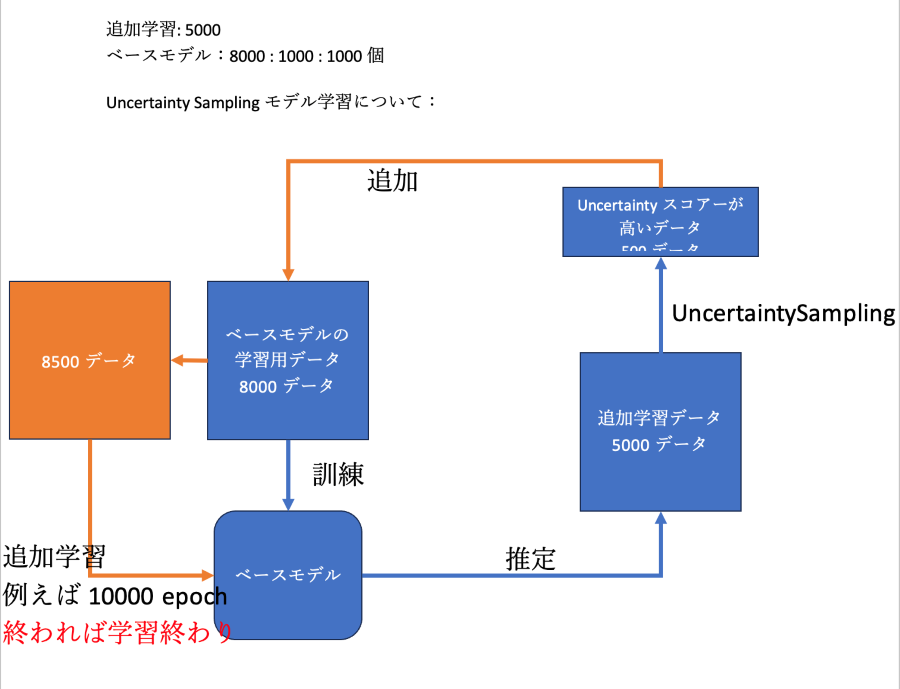

In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger, csv_logger],
    callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    devices=4, 
    strategy="ddp"
    )

trainer.fit(model=net, datamodule=data_module)
trainer.test(model=net, datamodule=data_module)